In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import fsolve
import torch
import torch.nn as nn
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

In [2]:
def DEIM(U):
    """
    Compute DEIM interpolation indices given
    U = {u_i}_i matrix with linearly independent columns.
    """
    U = np.copy(U)
    selected_indices = []
    
    for i in range(U.shape[1]):
        idx = np.argmax(np.abs(U[:, i]))
        selected_indices.append(idx)
        U = U - 1/U[idx, i] * U[:, [i]] @ U[[idx], :]
    
    return selected_indices

In [3]:
def weighted_mse_loss(input, target, weight):
    return (weight * (input - target) ** 2).mean()

class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 50)
        self.fc2 = nn.Linear(50, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x

def NEIM(ro_sols, f_NEIM, mu, V, max_modes=10, train_loop_iterations=10000):
    """
    Compute NEIM for solution
    independent nonlinearities.
    """
    NUM_PARAMS = f_NEIM.shape[0]
    RO_DIM = ro_sols.shape[1]
    
    WEIGHTS = np.array([[(abs(i - j) <= 1)/(1+10000*abs(i-j)**2) for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    #WEIGHTS = np.array([[np.exp(-100*np.abs(mu[i] - mu[j])) for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    #WEIGHTS = np.array([[(i == j)*1.0 for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    errors = np.array([np.sum(f_NEIM[i, i]**2) for i in range(NUM_PARAMS)])
    idx = np.argmax(errors)
    selected_indices.append(idx)
    print(idx, "Max Error:", errors[idx], "Mean Error:", np.mean(errors))
    
    Network_mu_1 = Net(RO_DIM, RO_DIM)
    mse_weights = torch.tensor(WEIGHTS[idx].reshape(-1, 1))
    optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)
    
    x_data = torch.tensor(ro_sols, dtype=torch.double)
    y_data = torch.tensor(np.array([f_NEIM[idx, j]/np.linalg.norm(f_NEIM[idx, j]) for j in range(f_NEIM.shape[1])]))
    
    for epoch in range(train_loop_iterations):
        optimizer.zero_grad()
        output = Network_mu_1(x_data)
        loss = weighted_mse_loss(output, y_data, mse_weights)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
    
    Network_mu_1.eval()
    trained_networks.append(Network_mu_1)
    
    thetas = np.zeros((NUM_PARAMS, 1), dtype=np.double)
    for i in range(NUM_PARAMS):
        numerator = 0
        denominator = 0
        for j in range(NUM_PARAMS):
            net_u_mu = Network_mu_1(x_data[j].view(1, -1)).detach().numpy().reshape(-1)
            numerator += WEIGHTS[i, j] * np.dot(f_NEIM[i, j], net_u_mu)
            denominator += WEIGHTS[i, j] * np.dot(net_u_mu, net_u_mu)

        theta_1_1_i = numerator / denominator
        thetas[i] = theta_1_1_i    
    
    for iteration in range(max_modes-1):
        # current approximation
        approx = lambda sol, param_idx: sum([
            thetas[param_idx][i] * net(torch.tensor(sol).view(1, -1)).T.detach().numpy().reshape(-1)\
            for i, net in enumerate(trained_networks)
        ])
    
        
        # Compute Errors and Choose New Parameter
        errors = np.array([np.sum((f_NEIM[i, i] - approx(ro_sols[i], i))**2) for i in range(NUM_PARAMS)])
        print("Mean Already Selected Error:", np.mean(errors[np.array(selected_indices)]))
        errors[np.array(selected_indices)] = -1
        mu_2_idx = np.argmax(errors)
        selected_indices.append(mu_2_idx)
        print(mu_2_idx, "Max Error:", errors[mu_2_idx], "Mean Error:", np.mean(errors[errors>=0]))
        
        Network_mu_2 = Net(RO_DIM, RO_DIM)
        mse_weights = torch.tensor(WEIGHTS[mu_2_idx].reshape(-1, 1))
        optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)


        # need to do Gram-Schmidt on this matrix
        previous_y_data = np.copy(y_data)
        y_data = np.copy(f_NEIM[mu_2_idx])
        
        for net in trained_networks:
            # form matrix of evaluations for this network
            previous_net_matrix = np.zeros((NUM_PARAMS, f_NEIM.shape[2]), dtype=np.double)
            for i in range(NUM_PARAMS):
                previous_net_matrix[i] = net(x_data[i].view(1, -1)).detach().numpy().reshape(-1)
                y_data[i] -= np.dot(y_data[i], previous_net_matrix[i]) * previous_net_matrix[i] / np.linalg.norm(previous_net_matrix[i])**2
        
        for j in range(f_NEIM.shape[1]):
             y_data[j] = y_data[j] / np.linalg.norm(y_data[j])
        
        y_data = torch.tensor(y_data, dtype=torch.double)
        
        for epoch in range(train_loop_iterations):
            optimizer.zero_grad()
            output = Network_mu_2(x_data)
            loss = weighted_mse_loss(output, y_data, mse_weights)
            if epoch % 100 == 0:
                print(epoch, loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

        Network_mu_2.eval()
        trained_networks.append(Network_mu_2)
        
        # 3c. Find theta_1_2(mu), theta_2_2(mu)
        print("\nFinding theta...")
        num_nets = len(trained_networks)
        thetas = np.zeros((NUM_PARAMS, num_nets), dtype=np.double)
        for i in range(NUM_PARAMS):
            LHS = np.zeros((num_nets, num_nets), dtype=np.double)
            RHS = np.zeros((num_nets, 1), dtype=np.double)

            for j in range(NUM_PARAMS):
                nets_u_mu = [net(x_data[j].view(1, -1)).detach().numpy().reshape(-1) for net in trained_networks]
                for k1 in range(num_nets):
                    RHS[k1] += WEIGHTS[i, j] * np.dot(f_NEIM[i, j], nets_u_mu[k1])
                    for k2 in range(num_nets):
                        LHS[k1, k2] += WEIGHTS[i, j] * np.dot(nets_u_mu[k1], nets_u_mu[k2])

            thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        
    def NEIM_approximation(new_mu, new_sol, num_modes=-1):
        if num_modes == -1:
            num_modes = len(trained_networks)
        
        new_sol = torch.tensor(new_sol)
        thetas_ = interpolate.griddata(mu, thetas, new_mu, method='cubic').reshape(-1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas, new_mu, method='nearest').reshape(-1)
        s = 0
        for i, net in enumerate(trained_networks[:num_modes]):
            s += thetas_[i] * net(new_sol.view(1, -1)).view(-1).detach().numpy()
        return s.reshape(-1)
    
    return NEIM_approximation, selected_indices

# Nonlinear parameterized function with spatial points in one dimension
Example from DEIM paper section 3.3.1:

We have a nonlinear parameterized function $s:\Omega\times\mathbb{R}\times\mathcal{D}\to\mathbb{R}$ defined by $$s(x, u;\mu) = (1-\lvert x\rvert)e^{-(1+x)u\mu},$$ where $\Omega = [-1, 1]$ and $\mu\in\mathcal{D} = [1,\pi]$.

Let $\boldsymbol{x} = [x_1,\dots,x_n]^\top\in\mathbb{R}^n$ with $x_i$ equally spaced points in $\Omega$ for $i=1,\dots,n$, with $n=100$. Define $f:\mathbb{R}\times\mathcal{D}\to\mathbb{R}^n$ by $$f(u; \mu) = [s(x_1, u;\mu),\dots,s(x_n, u;\mu)]^\top\in\mathbb{R}^n$$ for $\mu\in\mathcal{D}$. 

We then use 51 snapshots $f(u;\mu_j)$ to construct a POD basis $\{u_\ell\}_{\ell=1}^m$, with $\mu_1,\dots,\mu_{51}$ selected as equally spaced points in $[1,\pi]$.

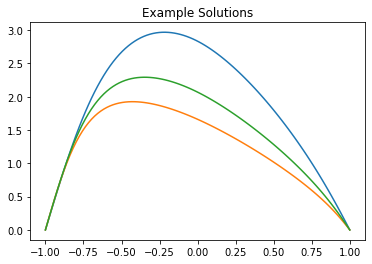

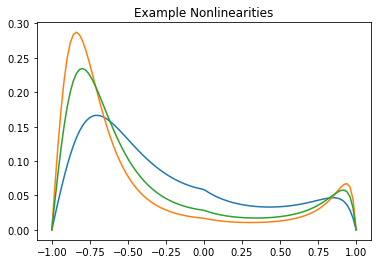

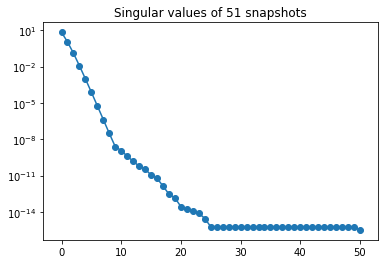

In [4]:
def s(u, x, mu):
    return mu * (1-np.abs(x)) * np.exp(-(1 + x) * u * mu)

def residual(A, u, x, mu):
    u[0] = 0
    u[-1] = 0
    r = (A @ u.reshape(-1, 1) - s(u.reshape(-1, 1), x, mu)).reshape(-1)
    return r

def solution_fn(x, mu):
    # compute full order solutions
    N = x.shape[0]
    A = 2*np.eye(N, dtype=np.double) - np.eye(N, k=1, dtype=np.double) - np.eye(N, k=-1, dtype=np.double)
    A = 30*A
    A[0, :] *= 0
    A[-1, :] *= 0
    A[:, 0] *= 0
    A[:, -1] *= 0
    sols = np.zeros((mu.shape[0], N), dtype=np.double)
    
    for i, m in enumerate(mu): # loop over parameters for nonlinearity
        sol = fsolve(lambda u: residual(A, u, x, m), np.zeros(N)).reshape(-1)
        sol[0] = 0
        sol[-1] = 0
        sols[i] = sol
    return sols

x = np.linspace(-1, 1, 100).reshape(-1, 1)
mu = np.linspace(1, np.pi, 51).reshape(-1,1).T
sols = solution_fn(x, mu.reshape(-1))

plt.plot(x, sols[0])
plt.plot(x, sols[-1])
plt.plot(x, sols[int(sols.shape[0]//2)])
plt.title("Example Solutions")
plt.show()

plt.plot(x, s(sols[0].reshape(-1), x.reshape(-1), mu.reshape(-1)[0]))
plt.plot(x, s(sols[-1].reshape(-1), x.reshape(-1), mu.reshape(-1)[-1]))
plt.plot(x, s(sols[sols.shape[0]//2].reshape(-1), x.reshape(-1), mu.reshape(-1)[sols.shape[0]//2]))
plt.title("Example Nonlinearities")
plt.show()

f = np.array([s(sols[i].reshape(-1, 1), x, mu[0, i]).reshape(-1) for i in range(sols.shape[0])]).T # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)
plt.plot(np.arange(sing_vals.shape[0]), sing_vals)
plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.yscale("log")
plt.title("Singular values of 51 snapshots")
plt.show()

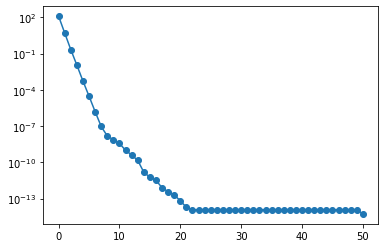

(100, 51)


In [5]:
RO_DIM = 30

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.semilogy(np.arange(sing_vals.shape[0]), sing_vals)
plt.show()
print(V.shape)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ s(sols[i].reshape(-1, 1), x, mu[0, j]).reshape(-1)).reshape(-1)

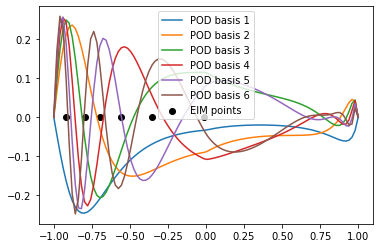

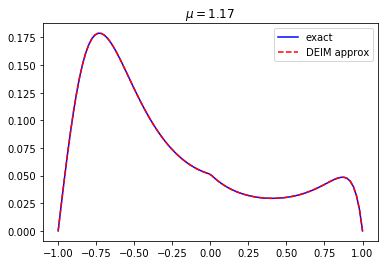

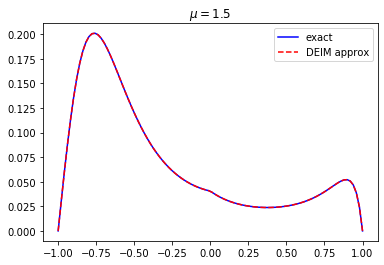

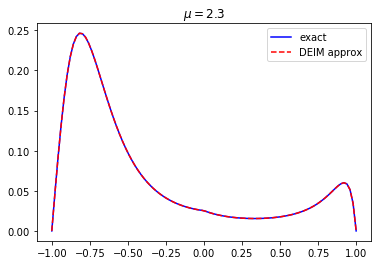

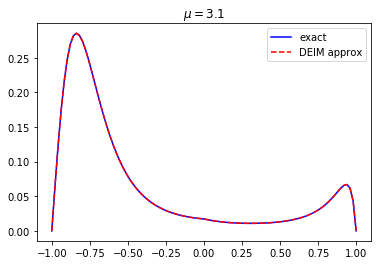

In [6]:
# Get DEIM indices
selected_indices = DEIM(u)

# plot POD basis vectors and first six spatial points
plt.scatter(x[selected_indices[:6]], np.zeros(6), c='black', label="EIM points")
for i in range(6):
    plt.plot(x, u[:, i], label=f"POD basis {i+1}")
plt.legend()
plt.show()

# look at DEIM approximations for these mu values and 10 DEIM modes
test_mu = [1.17, 1.5, 2.3, 3.1]
s_op = np.zeros((f.shape[0], 10)) # selection operator
for i, idx in enumerate(selected_indices[:10]):
    s_op[idx, i] = 1
DEIM_proj = u[:, :10] @ np.linalg.inv(s_op.T @ u[:, :10]) @ s_op.T # DEIM projection
for mu_val in test_mu:
    sol = solution_fn(x, np.array([mu_val]))
    exact = s(sol.reshape(-1, 1), x, mu_val)
    DEIM_approximation = DEIM_proj @ exact
    
    plt.plot(x, exact, label="exact", c='b')
    plt.plot(x, DEIM_approximation, label="DEIM approx", c='r', linestyle="dashed")
    plt.title(f"$\mu = {mu_val}$")
    plt.legend()
    plt.show()

# Compare Errors for POD, DEIM, NEIM

50 Max Error: 1.0479078125092798 Mean Error: 0.891267218950479
0 0.003227395672796627
100 3.352940641365823e-08
200 1.6972361165521797e-11
300 1.574433881500027e-11
400 1.574430761670681e-11
500 1.5744305363420434e-11
600 1.5744304381755474e-11
700 1.574430396117239e-11
800 1.5744303783105658e-11
900 1.5744303708426904e-11
1000 1.5744303677267586e-11
1100 1.5744303664335483e-11
1200 1.5744303658991608e-11
1300 1.5744303655920306e-11
1400 1.5744303652659166e-11
1500 1.5744303649179915e-11
1600 1.5744303645473558e-11
1700 1.5744303641534815e-11
1800 1.574430363735261e-11
1900 1.574430363291909e-11
2000 1.574430362822455e-11
2100 1.5744303623256763e-11
2200 1.5744303618006415e-11
2300 1.5744303612461707e-11
2400 1.574430360660886e-11
2500 1.5744303600435205e-11
2600 1.5744303593926412e-11
2700 1.5744303587068238e-11
2800 1.574430357984482e-11
2900 1.5744303572238886e-11
3000 1.57443035642346e-11
3100 1.5744303555812676e-11
3200 1.5744303546954676e-11
3300 1.5744303537639837e-11
3400 1.574

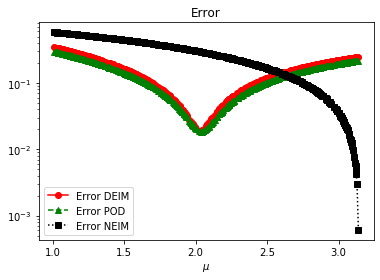

50 Max Error: 1.0479078125092798 Mean Error: 0.891267218950479
0 0.006260635167268184
100 8.646661333077444e-08
200 1.6417535286372757e-11
300 1.37697004512499e-11
400 1.3769628359262093e-11
500 1.3769626541818973e-11
600 1.3769625750284116e-11
700 1.376962541135457e-11
800 1.3769625267723529e-11
900 1.3769625207387049e-11
1000 1.3769625182213193e-11
1100 1.376962517176619e-11
1200 1.3769625167448344e-11
1300 1.3769625165137518e-11
1400 1.3769625162720823e-11
1500 1.3769625160142997e-11
1600 1.3769625157397103e-11
1700 1.376962515447881e-11
1800 1.376962515138019e-11
1900 1.3769625148095557e-11
2000 1.3769625144618057e-11
2100 1.3769625140938878e-11
2200 1.376962513705083e-11
2300 1.3769625132945463e-11
2400 1.3769625128613127e-11
2500 1.3769625124043831e-11
2600 1.3769625119228773e-11
2700 1.3769625114156689e-11
2800 1.3769625108815784e-11
2900 1.376962510319595e-11
3000 1.3769625097282899e-11
3100 1.376962509106501e-11
3200 1.3769625084527695e-11
3300 1.376962507765875e-11
3400 1.376

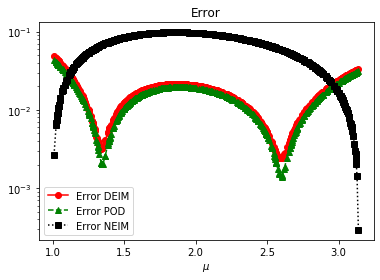

50 Max Error: 1.0479078125092798 Mean Error: 0.891267218950479
0 0.002970651979932464
100 5.179755383702033e-08
200 1.2278916338020376e-11
300 1.1106121138477703e-11
400 1.1106080025776432e-11
500 1.1106078611731065e-11
600 1.1106077995215392e-11
700 1.1106077730857501e-11
800 1.1106077618841556e-11
900 1.110607757179303e-11
1000 1.1106077552164108e-11
1100 1.110607754401914e-11
1200 1.1106077540652769e-11
1300 1.1106077538949895e-11
1400 1.1106077537204007e-11
1500 1.1106077535341269e-11
1600 1.1106077533356877e-11
1700 1.1106077531246268e-11
1800 1.110607752900544e-11
1900 1.1106077526629648e-11
2000 1.1106077524112898e-11
2100 1.1106077521449162e-11
2200 1.1106077518633293e-11
2300 1.1106077515658269e-11
2400 1.110607751251767e-11
2500 1.1106077509204098e-11
2600 1.1106077505709448e-11
2700 1.1106077502026706e-11
2800 1.110607749814694e-11
2900 1.1106077494060415e-11
3000 1.1106077489759018e-11
3100 1.1106077485232493e-11
3200 1.1106077480470048e-11
3300 1.1106077475460897e-11
3400 

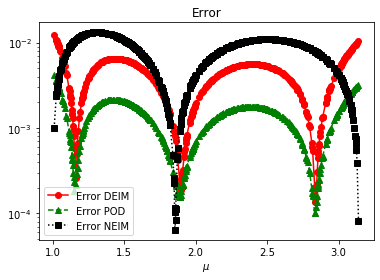

50 Max Error: 1.0479078125092798 Mean Error: 0.891267218950479
0 0.0044151129392397195
100 3.058846391139483e-08
200 1.322610292962772e-11
300 1.1846397067878636e-11
400 1.1846330120416537e-11
500 1.1846328085086164e-11
600 1.1846327197709224e-11
700 1.1846326817119442e-11
800 1.1846326655822905e-11
900 1.1846326588063846e-11
1000 1.1846326559792691e-11
1100 1.1846326548059574e-11
1200 1.1846326543210475e-11
1300 1.1846326540277265e-11
1400 1.184632653714064e-11
1500 1.184632653379325e-11
1600 1.184632653022774e-11
1700 1.1846326526435412e-11
1800 1.1846326522408393e-11
1900 1.1846326518137887e-11
2000 1.1846326513613547e-11
2100 1.1846326508827113e-11
2200 1.184632650376527e-11
2300 1.1846326498418735e-11
2400 1.1846326492774032e-11
2500 1.1846326486818684e-11
2600 1.1846326480539336e-11
2700 1.1846326473921905e-11
2800 1.1846326466951544e-11
2900 1.1846326459611403e-11
3000 1.1846326451885686e-11
3100 1.1846326443757572e-11
3200 1.1846326435208017e-11
3300 1.1846326426217975e-11
3400

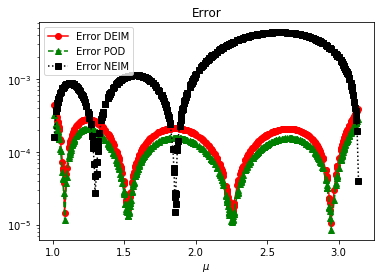

50 Max Error: 1.0479078125092798 Mean Error: 0.891267218950479
0 0.003893960502681085
100 4.89713870426589e-08
200 1.329489725821358e-11
300 1.2542514751549316e-11
400 1.2542482068663936e-11
500 1.2542481158790221e-11
600 1.2542480762948834e-11
700 1.2542480593394065e-11
800 1.254248052167191e-11
900 1.2542480491552226e-11
1000 1.2542480478987328e-11
1100 1.254248047377407e-11
1200 1.2542480471612402e-11
1300 1.2542480470081746e-11
1400 1.2542480468444176e-11
1500 1.2542480466697229e-11
1600 1.254248046483686e-11
1700 1.254248046285979e-11
1800 1.2542480460760891e-11
1900 1.2542480458536585e-11
2000 1.254248045618121e-11
2100 1.2542480453689988e-11
2200 1.2542480451056867e-11
2300 1.2542480448277484e-11
2400 1.2542480445343584e-11
2500 1.2542480442250416e-11
2600 1.254248043898926e-11
2700 1.254248043555459e-11
2800 1.2542480431937285e-11
2900 1.2542480428130532e-11
3000 1.254248042412566e-11
3100 1.2542480419912349e-11
3200 1.2542480415483105e-11
3300 1.2542480410826786e-11
3400 1.254

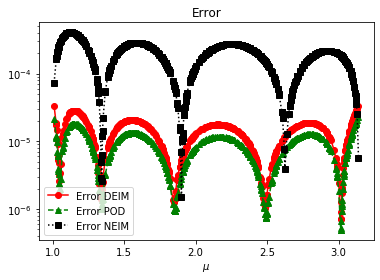

50 Max Error: 1.0479078125092798 Mean Error: 0.891267218950479
0 0.00483671034417615
100 7.441407915510703e-08
200 2.0146886467562053e-11
300 1.6175268024669816e-11
400 1.617516388587305e-11
500 1.617516151756849e-11
600 1.6175160485083243e-11
700 1.6175160042443907e-11
800 1.617515985492355e-11
900 1.6175159776178275e-11
1000 1.6175159743334025e-11
1100 1.617515972970762e-11
1200 1.6175159723769885e-11
1300 1.617515971853462e-11
1400 1.6175159712933557e-11
1500 1.6175159706956583e-11
1600 1.617515970058952e-11
1700 1.6175159693820008e-11
1800 1.617515968663375e-11
1900 1.617515967901346e-11
2000 1.6175159670943365e-11
2100 1.6175159662404725e-11
2200 1.617515965337933e-11
2300 1.6175159643845655e-11
2400 1.6175159633782803e-11
2500 1.6175159623168654e-11
2600 1.6175159611978047e-11
2700 1.617515960018674e-11
2800 1.6175159587767097e-11
2900 1.6175159574692177e-11
3000 1.61751595609321e-11
3100 1.6175159546456234e-11
3200 1.6175159531232715e-11
3300 1.6175159515226738e-11
3400 1.617515

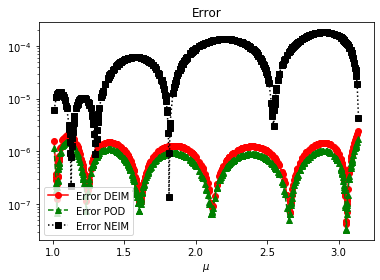

50 Max Error: 1.0479078125092798 Mean Error: 0.891267218950479
0 0.005475717265762463
100 7.653570007022373e-08
200 1.4346096557323589e-11
300 1.1926141621958267e-11
400 1.1926106307202122e-11
500 1.192610490904907e-11
600 1.1926104300003299e-11
700 1.1926104038837934e-11
800 1.1926103928174596e-11
900 1.1926103881695428e-11
1000 1.1926103862305762e-11
1100 1.1926103854265429e-11
1200 1.1926103850940423e-11
1300 1.1926103849326324e-11
1400 1.1926103847710509e-11
1500 1.1926103845986937e-11
1600 1.1926103844149629e-11
1700 1.192610384219531e-11
1800 1.1926103840119758e-11
1900 1.1926103837918723e-11
2000 1.1926103835586049e-11
2100 1.1926103833117627e-11
2200 1.1926103830507419e-11
2300 1.1926103827748912e-11
2400 1.1926103824835814e-11
2500 1.1926103821761523e-11
2600 1.1926103818518891e-11
2700 1.1926103815101353e-11
2800 1.1926103811499584e-11
2900 1.192610380770577e-11
3000 1.1926103803711357e-11
3100 1.1926103799505817e-11
3200 1.19261037950814e-11
3300 1.1926103790426859e-11
3400 

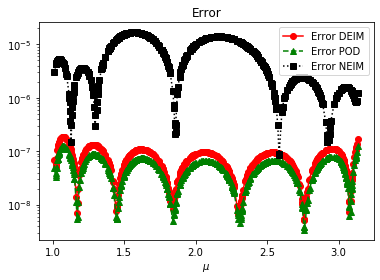

50 Max Error: 1.0479078125092798 Mean Error: 0.891267218950479
0 0.004465319109882281
100 7.11699749181527e-08
200 1.0190075647436504e-11
300 8.336282224041936e-12
400 8.336227240509983e-12
500 8.336226081679621e-12
600 8.336225576900255e-12
700 8.336225360444613e-12
800 8.336225268724056e-12
900 8.336225230200095e-12
1000 8.33622521412856e-12
1100 8.336225207459588e-12
1200 8.336225204704019e-12
1300 8.336225203022255e-12
1400 8.336225201222516e-12
1500 8.336225199301813e-12
1600 8.336225197255666e-12
1700 8.336225195079464e-12
1800 8.336225192768534e-12
1900 8.336225190318134e-12
2000 8.336225187722883e-12
2100 8.336225184976078e-12
2200 8.33622518207195e-12
2300 8.336225179004204e-12
2400 8.33622517576533e-12
2500 8.336225172348332e-12
2600 8.336225168744766e-12
2700 8.336225164947799e-12
2800 8.336225160947878e-12
2900 8.336225156735797e-12
3000 8.33622515230169e-12
3100 8.336225147636717e-12
3200 8.33622514273014e-12
3300 8.336225137569774e-12
3400 8.336225132144745e-12
3500 8.336

KeyboardInterrupt: 

In [7]:
MAX_MODES = 30
NUM_TRAIN_PARAMS = 51
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS).reshape(-1,1).T
sols = solution_fn(x, mu.reshape(-1))
f = np.array([s(sols[i].reshape(-1, 1), x, mu[0, i]).reshape(-1) for i in range(sols.shape[0])]).T # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

RO_DIM = 30

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ s(sols[i].reshape(-1, 1), x, mu[0, j]).reshape(-1)).reshape(-1)

test_mu = np.sort(np.random.uniform(size=501)*(np.pi-1)+1).reshape(-1,1).T
test_sols = solution_fn(x, test_mu.reshape(-1))
f_test = np.array([s(test_sols[i].reshape(-1, 1), x, test_mu[0, i]).reshape(-1) for i in range(test_sols.shape[0])]).T
proj_f_test = np.array([s(V[:, :RO_DIM] @ V[:, :RO_DIM].T @ test_sols[i].reshape(-1, 1), x, test_mu[0, i]).reshape(-1) for i in range(test_sols.shape[0])]).T

DEIM_errors = []
POD_errors = []
Actual_NEIM_errors = []

for num_modes in range(1, MAX_MODES+1, 1):
    s_op = np.zeros((f.shape[0], num_modes)) # selection operator
    for i, idx in enumerate(DEIM(u)[:num_modes]):
        s_op[idx, i] = 1
    DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection
    NEIM_approximation, NEIM_selected_indices = NEIM(ro_sols, f_NEIM, mu.reshape(-1), V[:, :RO_DIM], max_modes=num_modes, train_loop_iterations=10000) 
    print(NEIM_selected_indices)
    
    exact = V[:, :RO_DIM].T @ proj_f_test
    DEIM_approximation = V[:, :RO_DIM].T @ DEIM_proj @ proj_f_test
    POD_approximation = V[:, :RO_DIM].T @ u[:, :num_modes] @ u[:, :num_modes].T @ proj_f_test
    Actual_NEIM_approximation = np.array([NEIM_approximation(new_mu, (V[:, :RO_DIM].T @ test_sols[i].reshape(-1, 1)).reshape(-1), num_modes) for i, new_mu in enumerate(test_mu.reshape(-1))]).T
    
    avg_error = np.mean([np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    DEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - POD_approximation[:, i]) for i in range(exact.shape[1])])
    POD_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Actual_NEIM_errors.append(avg_error)
    
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='o', c='r', label="Error DEIM")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - POD_approximation[:, i]) for i in range(exact.shape[1])], marker='^', c='g', linestyle='dashed', label="Error POD")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', c='black', linestyle='dotted', label="Error NEIM")
    plt.yscale("log")
    plt.legend()
    plt.xlabel("$\mu$")
    plt.title("Error")
    plt.show()

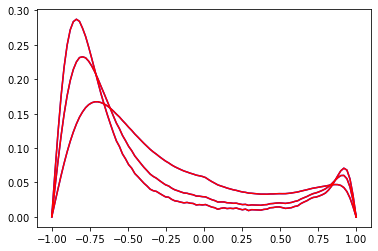

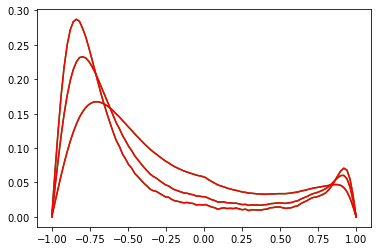

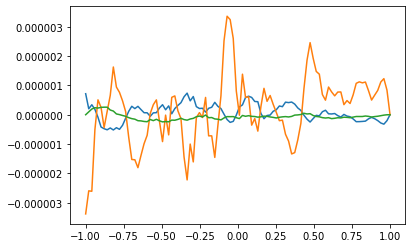

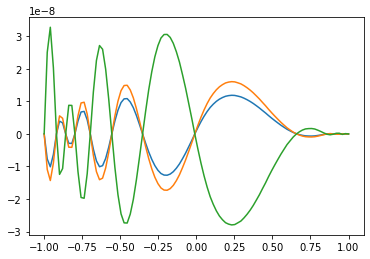

In [8]:
plt.plot(x, V[:,:RO_DIM] @ Actual_NEIM_approximation[:, 0], c='b')
plt.plot(x, V[:,:RO_DIM] @ Actual_NEIM_approximation[:, 250], c='b')
plt.plot(x, V[:,:RO_DIM] @ Actual_NEIM_approximation[:, -1], c='b')

plt.plot(x, V[:,:RO_DIM] @ exact[:, 0], c='r')
plt.plot(x, V[:,:RO_DIM] @ exact[:, 250], c='r')
plt.plot(x, V[:,:RO_DIM] @ exact[:, -1], c='r')
plt.show()

###########################################################

plt.plot(x, V[:,:RO_DIM] @ DEIM_approximation[:, 0], c='g')
plt.plot(x, V[:,:RO_DIM] @ DEIM_approximation[:, 250], c='g')
plt.plot(x, V[:,:RO_DIM] @ DEIM_approximation[:, -1], c='g')

plt.plot(x, V[:,:RO_DIM] @ exact[:, 0], c='r')
plt.plot(x, V[:,:RO_DIM] @ exact[:, 250], c='r')
plt.plot(x, V[:,:RO_DIM] @ exact[:, -1], c='r')
plt.show()

###########################################################

plt.plot(x, V[:,:RO_DIM] @ exact[:, 0] - V[:,:RO_DIM] @ Actual_NEIM_approximation[:, 0])
plt.plot(x, V[:,:RO_DIM] @ exact[:, 250] - V[:,:RO_DIM] @ Actual_NEIM_approximation[:, 250])
plt.plot(x, V[:,:RO_DIM] @ exact[:, -1] - V[:,:RO_DIM] @ Actual_NEIM_approximation[:, -1])
plt.show()

###########################################################

plt.plot(x, V[:,:RO_DIM] @ exact[:, 0] - V[:,:RO_DIM] @ DEIM_approximation[:, 0])
plt.plot(x, V[:,:RO_DIM] @ exact[:, 250] - V[:,:RO_DIM] @ DEIM_approximation[:, 250])
plt.plot(x, V[:,:RO_DIM] @ exact[:, -1] - V[:,:RO_DIM] @ DEIM_approximation[:, -1])
plt.show()